## Retrieval

In [1]:
import pandas as pd
import torch
import numpy as np
from datasets import Dataset

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-m-v2.0", trust_remote_code=True)
device = torch.device("cuda")
model.to(device)

print(torch.cuda.is_available())
print(next(model.parameters()).device)

Override attn_implementation='sdpa' to 'eager' as use_memory_efficient_attention='true'


True
cuda:0


In [2]:
"""
df_examples = pd.read_parquet('shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_products = pd.read_parquet('shopping_queries_dataset/shopping_queries_dataset_products.parquet')
#df_sources = pd.read_csv("shopping_queries_dataset/shopping_queries_dataset_sources.csv")

products = Dataset.from_pandas(df_products)
examples = Dataset.from_pandas(df_examples)

SMALL = False
products_ds = products.filter(lambda example: example['product_locale'] == "us")

examples_ds = examples.filter(lambda example: example['small_version'] == 1) #det här händer ju inte ens
examples_ds = examples.filter(lambda example: example['product_locale'] == "us")

if SMALL == True:
    train_split, products_ds = products_ds.train_test_split(test_size=0.01, seed=42).values()

from html.parser import HTMLParser

class HTMLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.text = []

    def handle_data(self, data):
        self.text.append(data)

    def get_text(self):
        return " ".join(self.text).strip()

def strip_html(text):
    if text is None:
        return ""
    stripper = HTMLStripper()
    stripper.feed(text)
    return stripper.get_text()

def concatenate_fields(example):
    fields = [example["product_title"], example["product_color"], example["product_brand"], example["product_description"]]
    filtered_fields = [strip_html(f) for f in fields if f]  # Remove HTML and None values
    example["combined_text"] = " ".join(filtered_fields).strip()
    return example

products_ds = products_ds.map(concatenate_fields)

cols_to_remove = products_ds.column_names
cols_to_remove.remove("product_id")
cols_to_remove.remove("combined_text")
corpus_ds = products_ds.remove_columns(cols_to_remove)

examples_ds = examples_ds.remove_columns("small_version")
examples_ds = examples_ds.remove_columns("large_version")
examples_ds = examples_ds.remove_columns("__index_level_0__")

examples_rel = examples_ds.filter(lambda example: example['esci_label'] == "E")
examples_rel = examples_rel.remove_columns("esci_label")
examples_rel = examples_rel.remove_columns("example_id")
examples_rel= examples_rel.remove_columns("product_locale")
qrel_ds = examples_rel.remove_columns("query")

query_ds = examples_rel.remove_columns("product_id")

seen = set()
query_ds = query_ds.filter(lambda example: example["query_id"] not in seen and not seen.add(example["query_id"]))

corpus_product_ids = set(products_ds['product_id'])

# REMOVE QUERIES WITH NO PRODUCTS
qrel_ds = qrel_ds.filter(lambda example: example['product_id'] in corpus_product_ids)
valid_query_ids = set(qrel_ds['query_id'])
query_ds = query_ds.filter(lambda example: example['query_id'] in valid_query_ids)

# SPLITS
qrel_train = qrel_ds.filter(lambda example: example['split'] == "train")
query_train = query_ds.filter(lambda example: example['split'] == "train")

qrel_test = qrel_ds.filter(lambda example: example['split'] == "test")
query_test = query_ds.filter(lambda example: example['split'] == "test")

qrel_train.save_to_disk("qrel_train")
query_train.save_to_disk("query_train")
qrel_test.save_to_disk("qrel_test")
query_test.save_to_disk("query_test")
corpus_ds.save_to_disk("corpus_ds") 
"""

'\ndf_examples = pd.read_parquet(\'shopping_queries_dataset/shopping_queries_dataset_examples.parquet\')\ndf_products = pd.read_parquet(\'shopping_queries_dataset/shopping_queries_dataset_products.parquet\')\n#df_sources = pd.read_csv("shopping_queries_dataset/shopping_queries_dataset_sources.csv")\n\nproducts = Dataset.from_pandas(df_products)\nexamples = Dataset.from_pandas(df_examples)\n\nSMALL = False\nproducts_ds = products.filter(lambda example: example[\'product_locale\'] == "us")\n\nexamples_ds = examples.filter(lambda example: example[\'small_version\'] == 1) #det här händer ju inte ens\nexamples_ds = examples.filter(lambda example: example[\'product_locale\'] == "us")\n\nif SMALL == True:\n    train_split, products_ds = products_ds.train_test_split(test_size=0.01, seed=42).values()\n\nfrom html.parser import HTMLParser\n\nclass HTMLStripper(HTMLParser):\n    def __init__(self):\n        super().__init__()\n        self.text = []\n\n    def handle_data(self, data):\n        se

In [1]:

from datasets import Dataset
from datasets import load_from_disk

qrel_train = load_from_disk("qrel_train")
query_train = load_from_disk("query_train")
qrel_test = load_from_disk("qrel_test")
query_test = load_from_disk("query_test")
corpus_ds = load_from_disk("corpus_ds")

In [ ]:
"""
query_embeddings = model.encode(query_test["query"], prompt_name="query", show_progress_bar=True)
query_embeds = np.array(query_embeddings)
np.save("query_test_embeds.npy", query_embeds)

query_embeddings_2 = model.encode(query_train["query"], prompt_name="query", show_progress_bar=True)
query_embeds_2 = np.array(query_embeddings_2)
np.save("query_train_embeds.npy", query_embeds_2)

document_embeddings = model.encode(corpus_ds["combined_text"], show_progress_bar=True)
doc_embeds = np.array(document_embeddings)
np.save('doc_embeds.npy', doc_embeds)"""

"""
query_embeddings_test = np.load('embeddings/query_test_embeds.npy')
query_embeddings_train = np.load("embeddings/query_train_embeds.npy")
document_embeddings = np.load('embeddings/doc_embeds.npy')
"""


In [ ]:
"""
import faiss # Create FAISS index (L2 normalized embeddings needed for dot product / cosine similarity)

dimension = query_embeddings_train.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner product (equivalent to cosine similarity if normalized)
faiss.normalize_L2(document_embeddings)
index.add(document_embeddings)  # Add documents to index# Normalize queries (if using cosine similarity)
faiss.normalize_L2(query_embeddings_train)# Perform search (retrieve top k similar docs per query)

k = 100  # Adjust as needed
scores, I = index.search(-1*query_embeddings_train, k)  # D = scores, I = indices of top-k docs
"""

In [ ]:
"""
I_train = np.load("faiss/faiss_index_train.npy")
scores_train = np.load("faiss/faiss_scores_train.npy")
neg_I_train = np.load("faiss/faiss_index_neg_train.npy")
neg_scores_train = np.load("faiss/faiss_scores_neg_train.npy")

I_test = np.load("faiss/faiss_index_test.npy")
scores_test = np.load("faiss/faiss_scores_test.npy")
neg_I_test = np.load("faiss/faiss_index_neg_test.npy")
neg_scores_test = np.load("faiss/faiss_scores_neg_test.npy")
"""

In [ ]:

import torch
import numpy as np
import pandas as pd
from datasets import Dataset

query_ids = query_train["query_id"]  # List of all query IDs
product_ids = corpus_ds["product_id"]  # List of all product IDs
query_ids = np.array(query_ids)
product_ids = np.array(product_ids)
k=100
scores_flat_train = scores_train.flatten()  # Convert the tensor to a flattened NumPy array
neg_scores_flat_train = neg_scores_train.flatten()
query_ids_flat = np.repeat(query_ids, k)
product_ids_flat = []
for ind in I_train.flatten():
    product_id = product_ids[ind]
    product_ids_flat.append(product_id)
flattened_scores_train = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": product_ids_flat,
    "score": scores_flat_train
})
neg_product_ids_flat = []
for ind in neg_I_train.flatten():
    product_id = product_ids[ind]
    neg_product_ids_flat.append(product_id)
neg_flattened_scores_train = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": neg_product_ids_flat,
    "score": neg_scores_flat_train
})

scores_ds_train = Dataset.from_pandas(flattened_scores_train)
neg_scores_ds_train = Dataset.from_pandas(neg_flattened_scores_train)

query_ids = query_test["query_id"]
scores_flat_test = scores_test.flatten()  # Convert the tensor to a flattened NumPy array
neg_scores_flat_test = neg_scores_test.flatten()
query_ids_flat = np.repeat(query_ids, k)
product_ids_flat = []
for ind in I_test.flatten():
    product_id = product_ids[ind]
    product_ids_flat.append(product_id)
flattened_scores_test = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": product_ids_flat,
    "score": scores_flat_test
})
neg_product_ids_flat = []
for ind in neg_I_test.flatten():
    product_id = product_ids[ind]
    neg_product_ids_flat.append(product_id)
neg_flattened_scores_test = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": neg_product_ids_flat,
    "score": neg_scores_flat_test
})

scores_ds_test = Dataset.from_pandas(flattened_scores_test)
neg_scores_ds_test = Dataset.from_pandas(neg_flattened_scores_test)

corpus_embed_ds = corpus_ds.map(lambda example, idx: {'embed_products': document_embeddings[idx].tolist()}, with_indices=True)
query_embed_train = query_train.map(lambda example, idx: {'embed_queries': query_embeddings_train[idx].tolist()}, with_indices=True)"
"""

In [24]:

def get_top_k_per_query(scores_ds: Dataset, k: int = 100) -> Dataset:
    """
    Filters the top k documents for each query based on their scores.

    Args:
        scores_ds (Dataset): A Hugging Face Dataset with columns 'query_id', 'product_id', and 'score'.
        k (int): The number of top documents to retain for each query. Default is 100.

    Returns:
        Dataset: A filtered Hugging Face Dataset containing only the top k documents for each query.
    """

    scores_df = scores_ds.to_pandas()

    #Sort by 'query_id' and 'score' (descending order)
    scores_df = scores_df.sort_values(by=['query_id', 'score'], ascending=[True, False])

    # Group by 'query_id' and retain top k rows for each query
    top_k_scores_df = (
        scores_df.groupby('query_id')
        .head(k)
        .reset_index(drop=True)
    )

    top_k_scores_ds = Dataset.from_pandas(top_k_scores_df)

    return top_k_scores_ds
"""
top_100_products_train = get_top_k_per_query(scores_ds_train,k=100)
bot_100_products_train = get_top_k_per_query(neg_scores_ds_train,k=100)
top_100_products_test = get_top_k_per_query(scores_ds_test,k=100)
bot_100_products_test = get_top_k_per_query(neg_scores_ds_test,k=100)
"""
top_100_products = get_top_k_per_query(scores_ds,k=100)

In [ ]:
def add_labels(top_100_dataset: Dataset, qrel: Dataset):
    new_col = []
    
    # Create a dictionary from qrel for fast lookup (query_id, product_id) => relevance label
    qrel_dict = {}
    for row in qrel:
        qrel_dict[(row['query_id'], row['product_id'])] = 1  # Relevant products are labeled as 1
    
    # Iterate through the top 100 dataset and add labels
    iterat = top_100_dataset.iter(batch_size=1)
    for i in iterat:
        query_id = i["query_id"][0]
        product_id = i["product_id"][0]
        
        # Check if the (query_id, product_id) exists in qrel_dict
        if (query_id, product_id) in qrel_dict:
            new_col.append(1)  # Label 1 if relevant
        else:
            new_col.append(0)  # Label 0 if not relevant

    # Add the new label column to the dataset
    top_100_dataset = top_100_dataset.add_column("label", new_col)
    
    return top_100_dataset

top_100_labels = add_labels(top_100_products, nano_qrels)

## NDCG

In [24]:
from datasets import Dataset
from sklearn.metrics import ndcg_score
import numpy as np

def ndcg_at_k(top_100_labels : Dataset, k, top_k):
    y_true = []
    y_score = []
    score_row = []
    true_row = []
    for i in range(top_100_labels.num_rows):
        score_row.append(top_100_labels[i]["score"])
        true_row.append(top_100_labels[i]["label"])
        if (i+1) % top_k == 0:
            y_true.append(true_row)
            y_score.append(score_row)
            score_row = []
            true_row = []

    y_score = np.array(y_score)
    y_true = np.array(y_true)
    return ndcg_score(y_true, y_score, k=k)  # Compute NDCG@10

#ndcg_score = ndcg_at_k(top_100_labels,k=10,top_k=100)
#print( f"NDCG@10 {ndcg_score}")

## SVM

In [11]:
top_100_product_ids = top_100_products["product_id"]
corpus_id = corpus_ds["product_id"]

product_ids = [top_100_product_ids[k*100:(k+1)*100] for k in range(len(query_embeddings_test))] # det finns nåt snyggare för det här

# get embeddings for top 100 products for all queries
product_embeddings = []
for product_ids_query in product_ids:
    product_embeddings_query = []
    for product_id in product_ids_query:
        product_embedding = document_embeddings[corpus_id.index(product_id)]
        product_embeddings_query.append(product_embedding) 
    product_embeddings.append(product_embeddings_query)


KeyboardInterrupt: 

In [9]:
corpus_id = corpus_ds["product_id"]
p_id_to_index={p_id: idx for idx,p_id in enumerate(corpus_id)}

In [11]:
top_100_product_ids = top_100_products["product_id"]
corpus_id = corpus_ds["product_id"]

print("start")
product_ids = [top_100_product_ids[k*100:(k+1)*100] for k in range(len(query_embeddings_test))] # det finns nåt snyggare för det här
print("klar med ids")

def embed_from_id(product_ids_query, document_embeddings, corpus_id):
    product_embeddings_query = []
    for product_id in product_ids_query:
        product_embedding = document_embeddings[p_id_to_index(product_id)]
        product_embeddings_query.append(product_embedding)
    return product_embeddings_query

# get embeddings for top 100 products for all queries
product_embeddings = np.zeros(len(query_embeddings_test))
product_embeddings = product_embeddings.tolist()

import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    future_embeddings = {executor.submit(embed_from_id, product_ids_query, document_embeddings, corpus_id): (idx,product_ids_query) for idx, product_ids_query in enumerate(product_ids)}
    for future in concurrent.futures.as_completed(future_embeddings):
        idx, _ = future_embeddings[future] 
        product_embeddings_query = future.result()
        product_embeddings[idx] = product_embeddings_query

start
klar med ids



KeyboardInterrupt



In [10]:
top_100_product_ids = top_100_products["product_id"]

top_100_product_ids = np.array(top_100_products["product_id"])
query_count = len(query_embeddings_test) 
# Efficiently reshape into (query_count, 100) using np.reshape 
product_ids = top_100_product_ids.reshape(query_count, 100) 
# Retrieve embeddings efficiently 
product_embeddings = np.array([ [document_embeddings[p_id_to_index[pid]] for pid in product_ids_query] for product_ids_query in product_ids ])

In [ ]:
bot_100_product_ids = bot_100_products["product_id"]

bot_100_product_ids = np.array(bot_100_products["product_id"])
query_count = len(query_embeddings_test) 
# Efficiently reshape into (query_count, 100) using np.reshape 
product_ids = bot_100_product_ids.reshape(query_count, 100) 
# Retrieve embeddings efficiently 
neg_product_embeddings = np.array([ [document_embeddings[p_id_to_index[pid]] for pid in product_ids_query] for product_ids_query in product_ids ])

NameError: name 'bot_1000_products' is not defined

In [21]:
np.save("bot_100_product_embeddings", neg_product_embeddings)

In [ ]:
import concurrent.futures
from sklearn import svm

def rerank(q_emb, p_emb, p_emb_neg, idx, yk):
    #börja mäta tid
    clf = svm.LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-6, C=1, dual='auto', loss="hinge")
    xk_neg = np.concatenate([q_emb[None,...], p_emb_neg])
    clf.fit(xk_neg,yk)
    xk = np.concatenate([q_emb[None,...], p_emb])
    similarity = clf.decision_function(xk)[1:].tolist()
    #sluta mäta tid
    return idx, similarity #kan få idx från future_similarities[future] också

yk = np.zeros(101)
yk[0] = 1
similarities = np.zeros(len(query_embeddings_test))
similarities = similarities.tolist()
# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    future_similarities = {executor.submit(rerank, q_emb, p_emb, p_emb_neg, idx, yk): (idx,(q_emb, p_emb, p_emb_neg)) for idx,(q_emb, p_emb, p_emb_neg) in enumerate(zip(query_embeddings_test, product_embeddings, neg_product_embeddings))}
    for future in concurrent.futures.as_completed(future_similarities):
        idx, similarity = future.result()
        similarities[idx] = similarity

# create flattened list of similarities
similarities = [
    score
    for scores in similarities
    for score in scores
]

In [ ]:
"""from sklearn import svm

clf = svm.LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-6, C=1, dual='auto', loss="hinge")
yk = np.zeros(101)
yk[0] = 1
similarities = []
for k in range(len(query_embeddings_test)):
    xk = np.concatenate([query_embeddings_test[k][None,...], product_embeddings[k]])
    clf.fit(xk,yk)
    similarity = clf.decision_function(xk)[1:].tolist()
    similarities.append(similarity)

# create flattened list of similarities
similarities = [
    score
    for scores in similarities
    for score in scores
]"""

In [ ]:
top_100_products_svm = top_100_labels
top_100_products_svm = top_100_products_svm.remove_columns("score")
top_100_products_svm = top_100_products_svm.add_column("score", similarities)

print(f"NDCG@10: {ndcg_at_k(top_100_products_svm, k=10,top_k=100)}")

NDCG@10: 0.41100903733691696


## Cross-encoder

### Initiate model

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch 
import torch.nn as nn

class SnowflakeClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_value):
        super().__init__() #ksk skicka in model_name
        self.transformer = AutoModel.from_pretrained(model_name, add_pooling_layer=False, trust_remote_code=True)
        self.dropout = nn.Dropout(dropout_value)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:,0,:]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

model_name = "Snowflake/snowflake-arctic-embed-m-v2.0"
num_labels = 2
dropout_value = 0.175
model_cross = SnowflakeClassifier(model_name, num_labels, dropout_value)
device = "cuda"
model_cross.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [4]:
nbr_layers = 0
for _,_ in model_cross.named_parameters():
    nbr_layers +=1

In [ ]:
# freeze transformer layers
for name, param in model_cross.named_parameters():
    if name.startswith("transformer"):
        param.requires_grad = False

# unfreeze some layers
for idx,(name, param) in enumerate(model_cross.named_parameters()):
    if idx>=nbr_layers-24:
        param.requires_grad = True

In [6]:
for idx,(name, param) in enumerate(model_cross.named_parameters()):
    if idx>110:
        print(name, param.requires_grad)

transformer.encoder.layer.9.attn_ln.bias False
transformer.encoder.layer.9.mlp_ln.weight False
transformer.encoder.layer.9.mlp_ln.bias False
transformer.encoder.layer.10.attention.qkv_proj.weight True
transformer.encoder.layer.10.attention.qkv_proj.bias True
transformer.encoder.layer.10.attention.o_proj.weight True
transformer.encoder.layer.10.attention.o_proj.bias True
transformer.encoder.layer.10.mlp.up_gate_proj.weight True
transformer.encoder.layer.10.mlp.down_proj.weight True
transformer.encoder.layer.10.mlp.down_proj.bias True
transformer.encoder.layer.10.attn_ln.weight True
transformer.encoder.layer.10.attn_ln.bias True
transformer.encoder.layer.10.mlp_ln.weight True
transformer.encoder.layer.10.mlp_ln.bias True
transformer.encoder.layer.11.attention.qkv_proj.weight True
transformer.encoder.layer.11.attention.qkv_proj.bias True
transformer.encoder.layer.11.attention.o_proj.weight True
transformer.encoder.layer.11.attention.o_proj.bias True
transformer.encoder.layer.11.mlp.up_gat

### Create triplets/choose examples

In [5]:
top_100_labels_train = load_from_disk("top_100_labels_train.npy")
bot_100_labels_train = load_from_disk("bot_100_labels_train.npy")

top_100_labels_test = load_from_disk("top_100_labels_test.npy")
bot_100_labels_test = load_from_disk("bot_100_labels_test.npy")

In [6]:
corpus_id = corpus_ds["product_id"]
p_id_to_index = {p_id: idx for idx,p_id in enumerate(corpus_id)}

In [12]:
import random

m = len(query_train["query"])
queries = query_train["query"]
query_ids = query_train["query_id"]
positives = []
negatives = []
qrel_queries = qrel_train["query_id"]
qrel_pos = qrel_train["product_id"]

labels = top_100_labels_train["label"]
product_ids = top_100_labels_train["product_id"]
for i in range(m):
    j = 0
    while j<100 and labels[i*100+j] == 0: #hämtar högst rankade relevanta produkten
        j += 1
    if j==100:
        idx = qrel_queries.index(query_ids[i])
        positives.append(corpus_ds[p_id_to_index[qrel_pos[idx]]]["combined_text"])#väljer en relevant om ingen fanns i top 100
    else:
        positives.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"]) 
"""
for i in range(m):
    j = 99
    while labels[i*100+j] == 1: #hämtar högst rankade relevanta produkten
        j -= 1
    negatives.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"])
"""

corpus_id = corpus_ds["product_id"]
corpus_text = corpus_ds["combined_text"]
qrel_dict = {}
for row in qrel_train:
    qrel_dict[(row["query_id"], row["product_id"])] = 1

for i in range(m):
    idx = random.randint(0,len(corpus_ds))
    while (query_ids[i], corpus_id[idx]) in qrel_dict: #väljer random icke-relevant produkt
        idx = random.randint(0,len(corpus_ds))
    negatives.append(corpus_text[idx])

train_dict = {"query": queries, "positive": positives, "negative": negatives}
train_dataset_triplet = Dataset.from_dict(train_dict).shuffle(seed=42)

In [13]:
n = len(query_test["query"])
queries = query_test["query"]
query_ids = query_test["query_id"]
positives = []
negatives = []
qrel_queries = qrel_test["query_id"]
qrel_pos = qrel_test["product_id"]

labels = top_100_labels_test["label"]
product_ids = top_100_labels_test["product_id"]
for i in range(n):
    j = 0
    while j<100 and labels[i*100+j] == 0: #hämtar högst rankade relevanta produkten
        j += 1
    if j==100:
        idx = qrel_queries.index(query_ids[i])
        positives.append(corpus_ds[p_id_to_index[qrel_pos[idx]]]["combined_text"])
    else:
        positives.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"]) #väljer en relevant om ingen fanns i top 100
"""
for i in range(n):
    j = 99
    while labels[i*100+j] == 1: #hämtar högst rankade relevanta produkten
        j -= 1
    negatives.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"])
"""
qrel_dict = {}
for row in qrel_test:
    qrel_dict[(row["query_id"], row["product_id"])] = 1

for i in range(n):
    idx = random.randint(0,len(corpus_ds))
    while (query_ids[i], corpus_id[idx]) in qrel_dict: #väljer random icke-relevant produkt
        idx = random.randint(0,len(corpus_ds))
    negatives.append(corpus_text[idx])

eval_dict = {"query": queries, "positive": positives, "negative": negatives}
eval_dataset_triplet = Dataset.from_dict(eval_dict).shuffle(seed=42)

### Create dataset with pairs of queries and examples

In [14]:
pairs = []
labels = []
for triplet in train_dataset_triplet:
    pairs.append([triplet["query"], triplet["positive"]])
    labels.append(1)
    pairs.append([triplet["query"], triplet["negative"]])
    labels.append(0)

train_dict = {"data": pairs, "label": labels}
train_dataset = Dataset.from_dict(train_dict)

In [15]:
pairs = []
labels = []
for triplet in eval_dataset_triplet:
    pairs.append([triplet["query"], triplet["positive"]])
    labels.append(1)
    pairs.append([triplet["query"], triplet["negative"]])
    labels.append(0)

eval_dict = {"data": pairs, "label": labels}
eval_dataset = Dataset.from_dict(eval_dict)

### Create dataloader

In [9]:
from datasets import load_from_disk
train_dataset = load_from_disk("train_dataset3")
eval_dataset = load_from_disk("eval_dataset3")

In [10]:
from datasets import Dataset
train_dataset = train_dataset[:25000]
eval_dataset = eval_dataset[:2000]

train_dataset = Dataset.from_dict(train_dataset).shuffle(seed=42)
eval_dataset = Dataset.from_dict(eval_dataset).shuffle(seed=42)

In [9]:
from torch.utils.data import TensorDataset, DataLoader

tokens = tokenizer(train_dataset["data"], padding=True, truncation=True, return_tensors="pt")
dataset = TensorDataset(tokens["input_ids"], tokens["attention_mask"], torch.tensor(train_dataset["label"]).to(device))
dataloader = DataLoader(dataset, batch_size=100, shuffle=False, drop_last=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_cross.parameters(), lr=1e-4)

eval_tokens = tokenizer(eval_dataset["data"], padding=True, truncation=True, return_tensors="pt")
eval_dataset = TensorDataset(eval_tokens["input_ids"], eval_tokens["attention_mask"], torch.tensor(eval_dataset["label"]).to(device))
eval_dataloader = DataLoader(eval_dataset, batch_size=100, shuffle=False, drop_last=True)

### Training loop

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCHS = 100
acc_train_history = []
acc_val_history = []
for epoch in tqdm(range(EPOCHS)):
    acc_train = 0
    j = 0
    model_cross.train()
    for input_ids, attention_mask, y_batch in dataloader:
        tokens = {"input_ids": input_ids.to(device), "attention_mask": attention_mask.to(device)} #får inte till på nåt annat sätt
        y_pred = model_cross(**tokens)
        loss = loss_fn(y_pred, y_batch.long())
        optimizer.zero_grad() #clears gradient before computing the new one
        loss.backward() #computes dloss/dx, gradient for all weights
        optimizer.step() #uses stored gradient to update each weight
        acc_train += torch.sum(y_batch == torch.argmax(y_pred, dim=-1))/y_batch.size()[0]
        j += 1

    acc_train_history += [acc_train.to("cpu")/j] #dela med hur många batches, cpu för att kunna plotta, annars måste man göra det för varje tensor i listan senare
    
    torch.save(model_cross, "cross_encoder_temp"+str(epoch)+".pt")

    model_cross.eval()
    with torch.no_grad():
        acc_val = 0
        j = 0
        for input_ids, attention_mask, y_val in eval_dataloader: # batches för minne
            tokens = {"input_ids": input_ids.to(device), "attention_mask": attention_mask.to(device)} #får inte till på nåt annat sätt
            y_val_pred = model_cross(**tokens)
            loss = loss_fn(y_val_pred, y_batch.long())
            acc_val += torch.sum(y_val == torch.argmax(y_val_pred, dim=-1))/y_val.size()[0]
            j += 1
        acc_val_history += [acc_val.to("cpu")/j] #cpu för att kunna plotta, annars måste man göra det för varje tensor i listan senare, j för batches
    """
    epochs = range(1, len(acc_train_history) + 1)
    plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
    plt.plot(epochs, acc_train_history, 'bo', label='Train accuracy')
    plt.title('Validation and training accuracy')
    plt.legend()
    plt.show()
    """

In [16]:
model_cross = torch.load("cross_encoder_temp14.pt", weights_only=False)

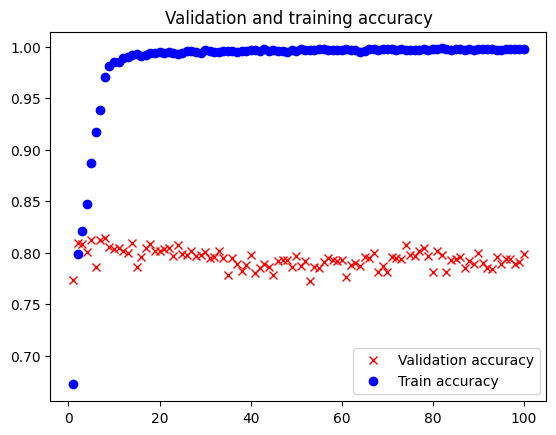

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc_train_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Train accuracy')
plt.title('Validation and training accuracy')
plt.legend()
plt.show()

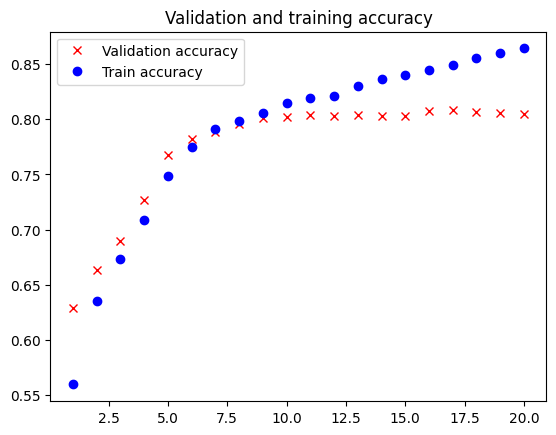

In [28]:
import matplotlib.pyplot as plt
e = 20

epochs = range(1, len(acc_train_history[:e]) + 1)
plt.plot(epochs, acc_val_history[:e], 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history[:e], 'bo', label='Train accuracy')
plt.title('Validation and training accuracy')
plt.legend()
plt.show()

### Train with trainer

In [ ]:
from datasets import Dataset, load_from_disk

train_dataset = load_from_disk("train_dataset3")
train_dataset = train_dataset[:25000]
train_dataset = Dataset.from_dict(train_dataset).shuffle(seed=42)

In [ ]:
def tokenize_fcn(examples):
    return tokenizer(examples["data"], padding="max_length", truncation=True)

train_dataset_tokenized = train_dataset.map(tokenize_fcn, batched=True)
train_dataset_tokenized = train_dataset_tokenized.rename_column("label", "labels")
train_dataset_tokenized = train_dataset_tokenized.remove_columns("data")

In [ ]:
# load tokenized datset
train_dataset_tokenized = load_from_disk("train_dataset_tokenized")

In [ ]:
train_dataset_tokenized

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

2673

In [15]:
from transformers import Trainer, TrainingArguments

model_name = "Snowflake/snowflake-arctic-embed-m-v2.0"
num_labels = 2
dropout_value = 0.1
device = "cuda"

#loss_fn = nn.CrossEntropyLoss()

training_args = TrainingArguments(
    output_dir = "crossencoder_temp",
    learning_rate = 1e-5,
    per_device_train_batch_size=10,
    num_train_epochs = 2,
    weight_decay = 0.01,
    #label_names = ["labels"],
    seed = 42
)

trainer = Trainer(
    model = model_cross,
    args = training_args,
    train_dataset = train_dataset_tokenized,
    #eval_dataset = eval_dataset,
    #processing_class = tokenizer,
    #data_collator = data_collator, ??
    #compute_loss_func= loss_fn
)

trainer.train()

Step,Training Loss
500,0.728800
1000,0.723500
1500,0.726600
2000,0.715600
2500,0.722100
3000,0.717000
3500,0.715400
4000,0.707500
4500,0.701700
5000,0.710800


TrainOutput(global_step=5000, training_loss=0.7168989990234375, metrics={'train_runtime': 1558.7114, 'train_samples_per_second': 32.078, 'train_steps_per_second': 3.208, 'total_flos': 0.0, 'train_loss': 0.7168989990234375, 'epoch': 2.0})

### Rerank

In [85]:

corpus_text = corpus_ds["combined_text"] #fult men snabbare
corpus_pid = corpus_ds["product_id"]
query_text = query_test["query"]
query_qid = query_test["query_id"]

p_id_to_index = {p_id: idx for idx,p_id in enumerate(corpus_pid)}
q_id_to_index = {q_id: idx for idx,q_id in enumerate(query_qid)}

def pid_to_text(pid):
    return corpus_text[p_id_to_index[pid]]
                     
def qid_to_text(qid):
    return query_text[q_id_to_index[qid]]

In [61]:
# hjälper ibland om problem med cuda-minne
import gc
torch.cuda.empty_cache()
gc.collect()

5373

In [ ]:
# create pairs
"""
top_100_labels_test = load_from_disk("top_100_labels_test.npy")
query_product_text = []
query_ids = top_100_labels_test["query_id"]
product_ids = top_100_labels_test["product_id"]
for q_id,p_id in zip(query_ids, product_ids):
    query_product_text.append([qid_to_text(q_id), pid_to_text(p_id)])
top_100_labels_test = top_100_labels_test.add_column("query_product_text", query_product_text)
"""

In [ ]:
# create smaller dataset for testing
"""
from datasets import Dataset
top_100_labels_test = top_100_labels_test.select(i for i in range(len(top_100_labels_test)) if i<1810000 and i%200000<10000)
top_100_labels_test = Dataset.from_dict(top_100_labels_test)
"""

Parameter 'indices'=<generator object <genexpr> at 0x7fc940ba79f0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [16]:
from torch.utils.data import TensorDataset, DataLoader
#top_100_labels_test = load_from_disk("test_top_100")
top_100_labels_test = load_from_disk("test_top_100_nano")

test_tokens = tokenizer(top_100_labels_test["query_product_text"], padding=True, truncation=True, return_tensors="pt")
test_dataset = TensorDataset(test_tokens["input_ids"], test_tokens["attention_mask"], torch.tensor(top_100_labels_test["label"]).to(device))
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [22]:
model_cross.eval()
logits = []
with torch.no_grad():
    for input_ids, attention_mask, y_batch in test_dataloader:
            tokens = {"input_ids": input_ids.to(device), "attention_mask": attention_mask.to(device)}
            outputs = model_cross(**tokens)
            logits.append(outputs["logits"])
logits = torch.cat(logits)
soft = nn.Softmax(dim=-1)
scores = soft(logits)
rerank_scores = scores[:,1]

In [25]:
# print score
temp_dataset = top_100_labels_test.remove_columns("score")
test_dataset_labels_scores = temp_dataset.add_column("score", rerank_scores.tolist())

print(f"NDCG@10: {ndcg_at_k(test_dataset_labels_scores, k=10,top_k=100)}")

NDCG@10: 0.0708711867617669


In [ ]:
# print retrieval score
print(f"NDCG@10: {ndcg_at_k(top_100_labels_test, k=10,top_k=100)}")

NDCG@10: 0.446485496066525
